# HDS assignment

## !!!!!Important!!!!!! 

## All files of the dataset should be stored at the same directory as this jupyter notebook for executing the code!

#### Introduction

* This report will be split into 2 parts. Function part which is about all the functions used and explain how they work, and the execution part where I executed the functions to get the answer of the questions and describe findings.

For this assignment, while solving each questions, I will be reading csv files individually to ensure the independency of the data as well as to avoid confusion while working with same pandas frame.

Even though, sometimes csv files will be read repetitively, it has following advantages. 

* It will prevent modified data from different quesitons being used. 

* Also, it will allow code of each question to be executed independently to improve performance while testing.

So, I decide to sacrifice the overall performance to decouple the functions and ensure they don't have dependency. 

I also used functions to modularise the problem to make the code more readable. All functions will be presented in this report first, all of the execution and final results of the questions will be at the end of this report. 





#### Global variable and Library import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

practicesName = "T201804ADDR+BNFT.CSV"
presFile = "T201804PDPI+BNFT.CSV"
columnNamePrac = ['code','surgury','surgery','address','city','county','postcode']
patiFile = "gp-reg-pat-prac-all.csv"


## Assignment A

### Function Part:

This is a function to read csv into pandas frame for all the questions to use. 

In [2]:
def readToPandas(name,columnName):
    if(columnName==None):
        pandasInfo = pd.read_csv(name)
    else:
        pandasInfo = pd.read_csv(name,skiprows=1, names =columnName)
    return pandasInfo

#### Q1.

Question 1 and 2 retrieves data about a certain range of practices and their patient number as well as prescription details. 

This is the function for retriving a list of practice's code in a city.
practiceInfo will be a dataframe retrieved from the csv file and city will be a string of the city's name. (Eg. 'London', 'Cambridge')

In [3]:
# return london practice code as list
def getCityPractice(practiceInfo,city):
    practiceInfo['city'] = practiceInfo['city'].str.strip()
    practiceInfo['county'] = practiceInfo['county'].str.strip()
    cityPrac = practiceInfo.loc[(practiceInfo['city'] == city) | (practiceInfo['county'] == city)]
    cityPracList = cityPrac['code'].tolist()
    return cityPracList


This is the function for getting the total number of patients, given a list of practice's codes. 

(parameter Q is the question number, irrelevant to the logic of the code)

In [4]:
# get total patient number related to the practiselist and also print practices that doesnt exists
def getPatientNumber(practiceList,Q):
    pati = readToPandas(patiFile,None)
    patiNumDict = dict(zip(pati.CODE, pati.NUMBER_OF_PATIENTS))
    sum = 0
    errorList = []
    for paticode in practiceList:
        if(paticode in patiNumDict.keys()):
            sum = sum + patiNumDict[paticode]
        else:
            errorList.append(paticode)
    print('Q'+str(Q)+' 1).total num of patients: ' + str(sum))
    print('      doesnt exist practice: ' + str(errorList))


This is the function for getting the total prescriptions, given a list of the practice's codes.

In [5]:
# get total number of prescriptions
def getTotalPres(practiceList,Q):
    presColumn = [' SHA', 'PCT', 'PRACTICE', 'BNF CODE', 'BNF NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY', 'PERIOD',
                  'Null']
    presInfo = readToPandas(presFile,presColumn)
    presQuantity = presInfo[['PRACTICE', 'ITEMS']]
    presQuantity = presQuantity.loc[presQuantity['PRACTICE'].isin(practiceList)][['PRACTICE','ITEMS']]
    presQuantity = presQuantity[['PRACTICE', 'ITEMS']]
    sum  = presQuantity['ITEMS'].sum()
    print('Q'+str(Q)+' 2).total num of prescription : ' + str(sum))

This is the function for getting the total cost of all the prescriptions, given a list of the practice's codes.

In [6]:
# get total cost of prescriptions
def getTotalPresCost(practiceList,Q):
    presColumn = [' SHA', 'PCT', 'PRACTICE', 'BNF CODE', 'BNF NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY', 'PERIOD',
                  'Null']
    presInfo = readToPandas(presFile, presColumn)
    presCost = presInfo[['PRACTICE','ITEMS', 'ACT_COST']]
    presCost = presCost.loc[presCost['PRACTICE'].isin(practiceList)][['PRACTICE', 'ITEMS','ACT_COST']]
    presCost = presCost[['PRACTICE', 'ITEMS','ACT_COST']]
# this line is for modify total cost, in case total cost is actual cost * item or * quantity
    presCost['TOTAL_COST'] = presCost['ACT_COST']

    sum = presCost['TOTAL_COST'].sum()
    print('Q'+str(Q)+' 3).total cost of prescription : ' + str(sum))

This is the function presenting the bottom 10 and the top 10 biggest quantity(most frequently used) prescriptions, given a list of the practice's codes. 

In [7]:
# get the top 10 and bottom 10 mostly prescribed prescriptions
def getFrequencyOfPres(practiceList,Q):
    presColumn = [' SHA', 'PCT', 'PRACTICE', 'BNF_CODE', 'BNF_NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY', 'PERIOD',
                  'Null']
    presInfo = readToPandas(presFile, presColumn)
    presFreq = presInfo[['PRACTICE','BNF_NAME','QUANTITY']]
    presFreqLn = presFreq.loc[presFreq['PRACTICE'].isin(practiceList)][['BNF_NAME','QUANTITY']]
    presFreqLn  = presFreqLn[['BNF_NAME','QUANTITY']]
    presFreqLn = presFreqLn.groupby('BNF_NAME').sum()
    presFreqLn = presFreqLn.sort_values('QUANTITY')

    print('Q'+str(Q)+' 4).most frequently used prescription : ' )
    print(presFreqLn.nlargest(10,'QUANTITY'))
    print('\n\n')
    print('Q'+str(Q)+' 4).least frequently used prescription : : ' )
    print(presFreqLn.nsmallest(10,'QUANTITY'))
    print('\n\n')

#### Q2.

Q2 will be reusing the code from Q1 but change the city name to Cambridge instead of London.

#### Q3.
This is the function to get all prescriptions in the csv file that is related to a certain disease. (Eg. cardiovascular disease (British National Formulary chapter, antidepressants (British National Formulary chapter 4.3))

ChapNum is the chapter number given as an ontology to identify the prescription of interest. 


The BNF code will be used in this case.

So if chapter 4.3 is given, then chapNum will be 0403 and any drug that BNF_CODE is began with 0403 will the the prescription of interest.

In [8]:
# get all prescriptions that is related to a specific disease or topic
def getAllPresRelatedToChapter(chapNum):
    presColumn = [' SHA', 'PCT', 'PRACTICE', 'BNF_CODE', 'BNF_NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY', 'PERIOD',
                  'Null']
    presInfo = readToPandas(presFile, presColumn)
    presCode = presInfo[['BNF_CODE', 'ITEMS','ACT_COST']]
    # find chapter related
    presCha = presCode.loc[lambda presCode: ((presCode.BNF_CODE > chapNum ) & (presCode.BNF_CODE < str(0)+str(int(chapNum)+1))), :]
    sum  = presCha['ITEMS'].sum()
    print('Q3.total num of prescription related to chapter' + chapNum + ' is '+str(sum))

    presCha = presCha[['BNF_CODE', 'ITEMS','ACT_COST']]
    presCha['TOTAL_COST'] = presCha['ACT_COST']

    totalcost = presCha['TOTAL_COST'].sum()
    print('Q3.total cost of prescription related to chapter' + chapNum + ' is '+str(totalcost))

#### Q4
The scatterplot function below will plot two diagrams for visualising the total spending and registered patients for each practice and then plot a scatter plot. Also a trendline will be fit to see the trend of the general summary of data points.

The plothist function will plot the histogram for relative spending per patients of all practices and if there is a trend of normal distribution, a normal curve will be fit to represent that distribution.


In [9]:
# Q4 1). plot a scatter plot for cost per patients and total cost of all of the patients in that practice
def scatterplot():
    presColumn = [' SHA', 'PCT', 'PRACTICE', 'BNF_CODE', 'BNF_NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY', 'PERIOD',
                  'Null']
    presInfo = readToPandas(presFile, presColumn)
    presInfo = presInfo[['PRACTICE','ACT_COST', 'ITEMS']]
    presInfo['TOTAL_COST'] = presInfo['ACT_COST']

    presUpdated = presInfo[['PRACTICE','TOTAL_COST']]
    presUpdated = presUpdated.groupby('PRACTICE').sum()

    # read in information about practice code and number of patients in that practice
    pati = readToPandas(patiFile, None)
    pati = pati[['CODE','NUMBER_OF_PATIENTS']]
    pati.rename(columns={'CODE':'PRACTICE'}, inplace=True)

    res = pd.merge(pati, presUpdated, on = 'PRACTICE')
    res['COST_PER_PATIENT'] = res['TOTAL_COST']/res['NUMBER_OF_PATIENTS']
    originalRowNum = len(res.index)

    # get rid of super small practice that has less than 1000 patients because the mean is 4592 and 25%- 75% interquatile range is 3020-5540
    res = res.loc[lambda res: (((res.NUMBER_OF_PATIENTS<35000) & (res.TOTAL_COST<75000000))), :]
    print(res.describe())
    print("Filtered out " + str(originalRowNum - len(res.index)) + " outliers.")
    x = res['NUMBER_OF_PATIENTS']
    y = res['TOTAL_COST']
    plt.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--",markersize=3)
    plt.xlabel("Patient Number")
    plt.ylabel("Total Cost")


    plt.show()

In [10]:
# Q4 2). plot the histogram for the cost per person for prescripitons
def plothist():
    presColumn = [' SHA', 'PCT', 'PRACTICE', 'BNF_CODE', 'BNF_NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY',
                  'PERIOD',
                  'Null']
    presInfo = readToPandas(presFile, presColumn)
    presInfo['TOTAL_COST'] = presInfo['ACT_COST']
# print pres info 
    print(presInfo.describe())
    presUpdated = presInfo[['PRACTICE','TOTAL_COST']]
    presUpdated = presUpdated.groupby('PRACTICE').sum()

    pati = readToPandas(patiFile, None)
    pati = pati[['CODE', 'NUMBER_OF_PATIENTS']]
    pati.rename(columns={'CODE': 'PRACTICE'}, inplace=True)
# merge two tables with key 'practice' and filter out out liers
    res = pd.merge(pati, presUpdated, on='PRACTICE')
    res['COST_PER_PATIENT'] = res['TOTAL_COST'] / res['NUMBER_OF_PATIENTS']
    res = res.loc[lambda res: (((res.COST_PER_PATIENT<30))), :]
    print(res.describe())
#  plot histogram for cost per patients
    df = pd.DataFrame({'A': res['COST_PER_PATIENT']})
    df.A.plot(kind='hist', density=True)
    mean = np.mean( res['COST_PER_PATIENT'])
    std = np.std( res['COST_PER_PATIENT'])
    range = np.arange(0, 30, 0.001)
    plt.xlabel("Cost Per Patient")
    plt.plot(range, norm.pdf(range, mean, std))
    plt.show()


### Execution Part and Answers: 

#### Q1.

Get london practice names for later use.
Store the practice' codes as a list in 'praclistLn' variable

In [36]:
praclistLn = getCityPractice(readToPandas(practicesName,columnNamePrac),'LONDON')

In [12]:
getPatientNumber(praclistLn,1)

Q1 1).total num of patients: 5841956
      doesnt exist practice: ['E85110', 'F83676', 'F84737', 'F84743', 'F84744', 'H85697', 'E87774', 'F84750', 'Y00416', 'Y00535', 'Y00672', 'Y00762', 'Y00936', 'Y01052', 'Y01162', 'Y01692', 'Y01704', 'Y01731', 'Y02085', 'Y02291', 'Y02292', 'Y02314', 'Y02315', 'Y02385', 'Y02408', 'Y02456', 'Y02522', 'Y02604', 'Y02785', 'Y02869', 'Y02914', 'Y03047', 'Y03077', 'Y03086', 'Y03094', 'Y03103', 'Y03106', 'Y03109', 'Y03127', 'Y03161', 'Y03201', 'Y03211', 'Y03243', 'Y03259', 'Y03304', 'Y03372', 'Y03387', 'Y03410', 'Y03433', 'Y03434', 'Y03461', 'Y03471', 'Y03479', 'Y03492', 'Y03493', 'Y03498', 'Y03504', 'Y03538', 'Y03575', 'Y03713', 'Y03766', 'Y03767', 'Y03768', 'Y03769', 'Y03781', 'Y03796', 'Y03897', 'Y03900', 'Y03901', 'Y03915', 'Y04091', 'Y04105', 'Y04140', 'Y04160', 'Y04183', 'Y04195', 'Y04274', 'Y04460', 'Y04474', 'Y04501', 'Y04502', 'Y04531', 'Y04551', 'Y04552', 'Y04647', 'Y04658', 'Y04681', 'Y04685', 'Y04690', 'Y04711', 'Y04729', 'Y04794', 'Y04828', 'Y0

In [13]:
getTotalPres(praclistLn,1)

Q1 2).total num of prescription : 5880634


In [14]:
getTotalPresCost(praclistLn,1)

Q1 3).total cost of prescription : 43322000.54


In [15]:
getFrequencyOfPres(praclistLn,1)

Q1 4).most frequently used prescription : 
                                          QUANTITY
BNF_NAME                                          
Ensure Plus_Milkshake Style Liq (9 Flav)  17023232
Metformin HCl_Tab 500mg                   11706703
Fortisip Bottle_Liq (8 Flav)              10217184
Lactulose_Soln 3.1g-3.7g/5ml               9283922
Paracet_Tab 500mg                          7690436
Dermol 500_Lot                             6717500
Ensure Compact_Liq (4 Flav)                6565947
Fresubin 2kcal_Drink (6 Flav)              6556352
Fortisip Compact_Liq (8 Flav)              5455500
Omeprazole_Cap E/C 20mg                    4665483



Q1 4).least frequently used prescription : : 
                                          QUANTITY
BNF_NAME                                          
Methotrexate_Inj 7.5mg/0.3ml Pfs                 0
Clini Med Cervical Collar Soft Foam              1
Lymed M/M For L/Extrem Class 2 Tights Fl         1
Lymed Acc For Lower Extremities Non-Stnd 

#### Answer for Q1:
    
1).Total number of patients is 5841956.
    
 Uncleaned Data: However, there exists practices that exists in the practice csv file but doesnt not exist in the patient csv file. This may be due to the human error while inputting. Uncleaned data is processed by excluding practices that doesnt exists in the patient csv file, because i feel it is very hard to estimate the patient number in those practices logically. These code are presented as well in the form of a list for future use. 
    
2).Total num of prescription : 5880634
    
3).Total cost of prescription : 43322000
    
For the prescription cost, I use act_cost column as the total cost of this prescripition,assuming act_cost is the price of a single prescription. 

4).Top 10 most frequently used prescriptions are:

Ensure Plus_Milkshake Style Liq (9 Flav)  
Metformin HCl_Tab 500mg                   
Fortisip Bottle_Liq (8 Flav)              
Lactulose_Soln 3.1g-3.7g/5ml               
Paracet_Tab 500mg                          
Dermol 500_Lot                             
Ensure Compact_Liq (4 Flav)                
Fresubin 2kcal_Drink (6 Flav)              
Fortisip Compact_Liq (8 Flav)              
Omeprazole_Cap E/C 20mg                    

5).Top 10 least frequently used prescriptions are:

Methotrexate_Inj 7.5mg/0.3ml Pfs                 
Clini Med Cervical Collar Soft Foam              
Lymed M/M For L/Extrem Class 2 Tights Fl         
Lymed Acc For Lower Extremities Non-Stnd         
Trevicta_Inj 263mg/1.315ml Pfs P/R               
Trio_Silken Slc Stoma Gel 60g                    
Bard Slc Elastomer-Ctd Ltx Foy Fle 30ml          
LoFric Non PVC Nelaton Paed 30cm 8-10(30         
LoFric Non PVC Nelaton Paed 20cm 6 (30-P         
LoFric Insti-Cath Nelaton Male 8-14(30-P        
    
For top 10 least frequently used prescriptions, because more than 10 prescriptions are used only once, so there are more prescriptions fitting this criteria. So in this report, for presentation use, the prescriptions will be chosen based on the order of presents of the prescription in the csv file.
    

   #### Q2
   For question 2, I will be using the same functions as question 1. I will pass the city name cambridge as an argument to the functions to get a list of practice's code in Cambridge.

In [16]:
praclistCA = getCityPractice(readToPandas(practicesName,columnNamePrac),'CAMBRIDGE')
praclistCA

['D81001',
 'D81002',
 'D81003',
 'D81005',
 'D81009',
 'D81012',
 'D81013',
 'D81016',
 'D81017',
 'D81025',
 'D81028',
 'D81033',
 'D81035',
 'D81037',
 'D81041',
 'D81042',
 'D81043',
 'D81044',
 'D81051',
 'D81054',
 'D81055',
 'D81056',
 'D81058',
 'D81066',
 'D81070',
 'D81078',
 'D81084',
 'D81086',
 'D81602',
 'D81607',
 'Y00056',
 'Y01778',
 'Y02991',
 'Y03550',
 'Y04602',
 'Y05839']

In [17]:
getPatientNumber(praclistCA,2)

Q2 1).total num of patients: 311579
      doesnt exist practice: ['Y01778', 'Y02991', 'Y03550', 'Y04602', 'Y05839']


In [18]:
getTotalPres(praclistCA,2)

Q2 2).total num of prescription : 345532


In [19]:
getTotalPresCost(praclistCA,2)

Q2 3).total cost of prescription : 2434403.94


In [20]:
getFrequencyOfPres(praclistCA,2)

Q2 4).most frequently used prescription : 
                                          QUANTITY
BNF_NAME                                          
Fortisip Compact_Liq (8 Flav)               924625
Nutrison Pack_Energy                        651324
Paracet_Tab 500mg                           573923
Fortisip Bottle_Liq (8 Flav)                508936
Dermol 500_Lot                              447500
Omeprazole_Cap E/C 20mg                     443650
Nutrison Pack_Energy M/Fibre                437716
Lactulose_Soln 3.1g-3.7g/5ml                420220
Metformin HCl_Tab 500mg                     328345
Nutrison Pack_Conc Liq                      298500



Q2 4).least frequently used prescription : : 
                                          QUANTITY
BNF_NAME                                          
Picato_Gel 500mcg/g                              0
Hollister Infyna Plus Hydro Intermit Fle         1
BioXtra Dry Mth Mild Toothpaste 50ml (Ap         1
BioXtra Dry Mth Gel Mth Spy 50ml (App)   

#### Answer for Q2:

Same methodology is applied as question 1. So the code of question one can be reused for Q2.

1).Total number of patients is 311579.

Uncleaned data will be processed in the same way as question 1.

2).Total num of prescription : 345532

3).Total cost of prescription : 2434403

4).Top 10 most frequently used prescriptions are:

Fortisip Compact_Liq (8 Flav)               
Nutrison Pack_Energy                        
Paracet_Tab 500mg                           
Fortisip Bottle_Liq (8 Flav)                
Dermol 500_Lot                              
Omeprazole_Cap E/C 20mg                     
Nutrison Pack_Energy M/Fibre                
Lactulose_Soln 3.1g-3.7g/5ml                
Metformin HCl_Tab 500mg                     
Nutrison Pack_Conc Liq                      
                     
5).Top 10 least frequently used prescriptions are:

Picato_Gel 500mcg/g                              
Hollister Infyna Plus Hydro Intermit Fle         
BioXtra Dry Mth Mild Toothpaste 50ml (Ap         
BioXtra Dry Mth Gel Mth Spy 50ml (App)           
Enopen Crm 500g                                  
NovoPen Echo Red Pen 3ml 0.5u (0.5-30u)          
Flutter Oscillating Positive Expiratory          
Ins Lantus_100u/ml 10ml Vl                       
Coloplast_Brava Belt (For Sensura Mio) S         
ReadyWrap Knee Lymph Gmt                             

For top 10 least frequently used prescriptions, because more than 10 prescriptions are used only once, so there are more prescriptions fitting this criteria. So in this report, for presentation use, the prescriptions will be chosen based on the order of present of the prescription in the csv file.

#### Discuss and Compare Q1 and Q2

In April 2018, London had around 18 times more patients than cambridge has. The prescription ratio is slightly higher, London used 20 times more prescriptions than Cambridge did. This means London patients uses more prescriptions. The ratio of the total cost is also 20, this means the price of individual drugs being used by London patients and Cambridge patients are similar.

For the prescriptions, both cities used Fortisip, Lactulose_Soln, Dermol, Omeprazole_Cap, Metformin, Paracet_Tab very frequently, 6 out of 10 drugs are on the top 10 most frequently used list for both cities, meaning both cities has very similar popular prescription structure.




   #### Q3

In [21]:
getAllPresRelatedToChapter('02')

Q3.total num of prescription related to chapter02 is 26449832
Q3.total cost of prescription related to chapter02 is 90193834.01999994


In [22]:
getAllPresRelatedToChapter('0403')

Q3.total num of prescription related to chapter0403 is 5715873
Q3.total cost of prescription related to chapter0403 is 16853470.86


Answer for Q3:

I retrieved all of the prescriptions related to cardiovascular disease by selecting all rows with the BNF_CODE that started with 02, which represents British National Formulary chapter 2. 

Then I found the total cost of all prescriptions under British National Formulary chapter 2 to get the total cost of prescriptions individually and then sum them up. 

1). Total number of prescription related to cardiovascular disease across all practices is: 26449832

2). Total cost of prescription related to cardiovascular disease across all practices is: 90193834


3). Total number of prescription related to antidepressants across all practices is: 5715873

4). Total cost of prescription related to antidepressants across all practices is: 16853470

The total number of prescriptions related to cardiovascular disease in UK practices is almost 5 times more than the total number of prescription related to antidepressants. This may be due to the fact that the cardiovascular disease is more common and also more general compare to the antidepressants. Factors like usage of the prescription and the quantity of each prescripition item should also be taken into account while explaining the findings.
   
   

#### Q4

       NUMBER_OF_PATIENTS     TOTAL_COST  COST_PER_PATIENT
count         7167.000000    7167.000000       7167.000000
mean          8084.409934   86729.663160         11.614222
std           4674.848379   54996.500632         38.933256
min              3.000000       3.250000          0.001724
25%           4547.000000   45016.805000          8.876875
50%           7249.000000   76007.140000         10.916036
75%          10700.500000  117392.910000         12.695096
max          33501.000000  472709.770000       2830.020000
Filtered out 24 outliers.


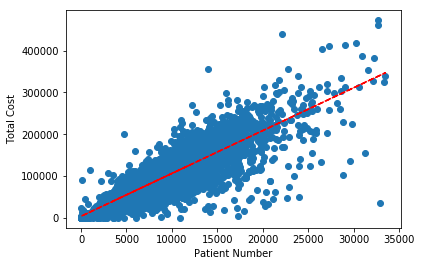

In [23]:
scatterplot()

              ITEMS           NIC      ACT_COST      QUANTITY     PERIOD  \
count  9.748354e+06  9.748354e+06  9.748354e+06  9.748354e+06  9748354.0   
mean   9.115409e+00  7.078242e+01  6.597908e+01  7.135560e+02   201804.0   
std    2.999382e+01  1.918400e+02  1.782526e+02  4.124964e+03        0.0   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   201804.0   
25%    1.000000e+00  7.920000e+00  7.460000e+00  2.800000e+01   201804.0   
50%    2.000000e+00  2.250000e+01  2.112000e+01  9.000000e+01   201804.0   
75%    6.000000e+00  6.286000e+01  5.868000e+01  3.360000e+02   201804.0   
max    5.147000e+03  3.391873e+04  3.145594e+04  2.281694e+06   201804.0   

         TOTAL_COST  
count  9.748354e+06  
mean   6.597908e+01  
std    1.782526e+02  
min    0.000000e+00  
25%    7.460000e+00  
50%    2.112000e+01  
75%    5.868000e+01  
max    3.145594e+04  
       NUMBER_OF_PATIENTS     TOTAL_COST  COST_PER_PATIENT
count         7172.000000    7172.000000       7172.000000

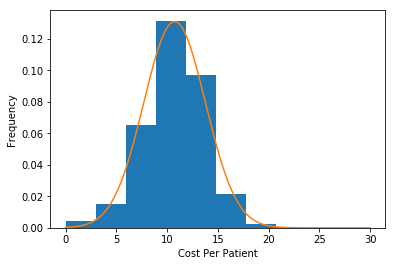

In [24]:
plothist()

#### Answer for Q4

I retrieved data from both files containing prescription and patient information. The total spending of each practice can be found through finding the total cost of each prescription and then summing up all of the prescriptions of each practices. Then the number of patients of each practices can be identified so that the relative cost per patient can be found.

For the scatter plot, 24 outliers is filtered out. The filtering is based on removing outliers that are extremely far away from the main trend. Each dot represent a practice and the y axis is the total cost and the x axis is the total number of patients in that practice. The trend line shows that there exists a relationship between number of patients in that practice and the total spending of that practice. The more patients they have, the more spending they have, which can be logically explained as more patients meaning more prescriptions being prescribed. 

For the histogram, the outliers with extremely high cost per patient is filtered out for a more readible histogram. There are 7107 number of practices and their mean cost per patient is 10 pounds per month. The normal curve fits almost perfectly to the graph indicating that the relative spending of all practices in UK are normally distributed. Most of the practices have a relative spending that is around 10 pounds. Slightly more practices have a relative spending that is higher than the mean. 



## Assignment B

For retrieveing data from WHO mortality Database, I imported pandasql for an easier approach while retrieving data. It will be used along with pandas data frame manipulation. Also, as there are more columns for the age distribution information as well as requirement in modifying column names and sql queries manage them easier. 

### Function Part: 

In [25]:
from pandasql import PandaSQL
pdsql = PandaSQL()
pd.set_option('display.max_columns', 500)

#### Q1
The function need to be reused for three different countries therefore the country name is passed as a parameter. It will read country code csv file into a pandas data frame and look up the code for specific countries. Then the population file will be read. Because year 2010 is fixed so it is not passed as a parameter but hard coded into the code, however, it can be passed in as a parameter based on different requirements.

After the poupulation of a country in a specific year is found, the death number can also be found using the same way. However, as death information has 2 files, the pandas data frame needs to be merged into one. 

In [26]:
# find details about the country including the total population and total death
def findDetail(country):
#     find country code
    countryDf = readToPandas('country_codes.csv',None)
    code = countryDf.loc[(countryDf['name'] == country)]['country']
    code=code.values[0]
#     read in and select population data
    popDF = readToPandas('pop.csv',None)
    pop = popDF.loc[(popDF['Country'] == code)]
    pop = pdsql("SELECT * FROM pop WHERE year == 2010", locals())
    pop = pop.groupby('Country').sum()
    totalPopulation = pop['Pop1'].values[0]
    print("Q1: total population of "+country +" is " + str(totalPopulation))
#   read in and select death data
    deathDF1 = readToPandas('Morticd10_part1.csv',None)
    deathDF2 = readToPandas('Morticd10_part2.csv',None)
    deathDF= deathDF1.append(deathDF2)
    deathDF = deathDF.loc[(deathDF['Country'] == code)]
    death = pdsql("SELECT * FROM deathDF WHERE Year == 2010", locals())
    death = death.groupby('Country').sum()
    totalDeath = death['Deaths1'].values[0]
    print("Q1: total death of "+country +" is " + str(totalDeath))

####  Q2
I tried to visualise the distribution of death by histogram. However, i think it will be clearer to see the distribution of death by age group with a bar chart as histogram does not clearly reflect the exact age group with specific death number. 

A bar chart will be ploted by this function with x axis of age group and y axis of the death number.

In [27]:
# draw a hisogram for the death number for age groups

# Q2
def histForItaly(country):
    countryDf = readToPandas('country_codes.csv', None)
    code = countryDf.loc[(countryDf['name'] == country)]['country']
    code = code.values[0]

    deathDF1 = readToPandas('Morticd10_part1.csv', None)
    deathDF2 = readToPandas('Morticd10_part2.csv', None)

    deathDF = deathDF1.append(deathDF2)
    death = deathDF.loc[(deathDF['Country'] == code)]

    death = death.groupby('Country').sum()
    print(death)
# create x and y for the graph 
    x = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
    y =[]
    y.append(death['Deaths2'].values[0]+death['Deaths3'].values[0]+death['Deaths4'].values[0]+death['Deaths5'].values[0]+death['Deaths6'].values[0])
    y.append(death['Deaths7'].values[0])
    y.append(death['Deaths8'].values[0])
    y.append(death['Deaths9'].values[0])
    y.append(death['Deaths10'].values[0])
    y.append(death['Deaths11'].values[0])
    y.append(death['Deaths12'].values[0])
    y.append(death['Deaths13'].values[0])
    y.append(death['Deaths14'].values[0])
    y.append(death['Deaths15'].values[0])
    y.append(death['Deaths16'].values[0])
    y.append(death['Deaths17'].values[0])
    y.append(death['Deaths18'].values[0])
    y.append(death['Deaths19'].values[0])
    y.append(death['Deaths20'].values[0])
    y.append(death['Deaths21'].values[0])
    y.append(death['Deaths22'].values[0])
    y.append(death['Deaths23'].values[0])
    y.append(death['Deaths24'].values[0])
    y.append(death['Deaths25'].values[0])

    graph = pd.DataFrame({'deathNum': y,'agegroup' :x})
    plot = graph.plot.bar(y = 'deathNum',x = 'agegroup',rot=0)
    plt.show()



#### Q3
This function sums up the death for each different death course across all years for neoplasm. The ICD10 code is used for selecting the death numbers and their causes. The top 5 most common death causes are selected along with their death number and percentages. Then a pie chart will be drawn based on it. All other causes will be merged into one section of the pie as some of them are too small to be readable from the chart. 


In [28]:
#Q3 find the top 5 most common death causes and plot them into a pie chart
def NeoDeath(country):
    countryDf = readToPandas('country_codes.csv', None)
    code = countryDf.loc[(countryDf['name'] == country)]['country']
    code = code.values[0]
# read in data
    deathDF1 = readToPandas('Morticd10_part1.csv', None)
    deathDF2 = readToPandas('Morticd10_part2.csv', None)
    deathDF = deathDF1.append(deathDF2)
# select data and sum them up
    death = deathDF.loc[(deathDF['Country'] == code)]
    death1=death[['Country','Cause','Deaths1']]
    deathPoll = pdsql("SELECT Cause,SUM(Deaths1) as deathNum FROM death1 WHERE Cause >= 'C00' AND Cause <= 'D48'  GROUP BY Cause", locals())
    Total = deathPoll['deathNum'].sum()
# print table and graph
    deathPoll['Percentage'] =  deathPoll['deathNum'] / Total
    deathPollPie = deathPoll.nlargest(5,'Percentage')
    temp = pd.DataFrame([['Other', Total*(1-deathPollPie['Percentage'].sum()),(1-deathPollPie['Percentage'].sum())]], columns=['Cause','deathNum','Percentage'])
    deathPollPie1 = deathPollPie.append(temp)
    print(deathPollPie1)
    plot = deathPollPie1.plot.pie(ax = None, y='deathNum', figsize=(10,10), legend=True,
                            autopct='%1.0f%%', pctdistance=0.9, radius=1.2,labels=deathPollPie1.Cause)
    plt.show()

#### Q4 
For question 4, this question is used for rank the top 5 age group of death caused by neoplasm. 

Data is filtered by countries, year, cause separately for debugging purposes. 

After retrieving data, a transpose need to be implemented on the matrix to swap rows and columns so that all ages groups can be formed into one column of rows. Any irrelevant columns will be dropped before transpose.



In [29]:
# Q4 rank the top 5 age group of death caused by neoplasm
def rankNeoDeath(country):
    countryDf = readToPandas('country_codes.csv', None)
    code = countryDf.loc[(countryDf['name'] == country)]['country']
    code = code.values[0]
# read in data
    deathDF1 = readToPandas('Morticd10_part1.csv', None)
    deathDF2 = readToPandas('Morticd10_part2.csv', None)
    deathDF = deathDF1.append(deathDF2)
# select neoplasm within 2010 in specific country
    deathCountry = deathDF.loc[(deathDF['Country'] == code)]
    deathYear = deathCountry.loc[(deathCountry['Year'] == 2010)]
    deathPoll = pdsql("SELECT *  FROM deathYear WHERE Cause >= 'C00' AND Cause <= 'D48' ", locals())
# sum up by country
    deathPoll = deathPoll.groupby('Country').sum()
    deathPollD = deathPoll.drop(['Deaths1','List','Year','Sex','Frmat','IM_Frmat'],axis=1)
# transpose
    deathPollTrans = deathPollD.T
    print(deathPollTrans.nlargest(5,deathPollTrans.columns.values[0]))

#### Q5
This function compares data from two different countries. Country names are passed in as parameters and two identical pandas data frame will be used to store same information from two different countries.

Then, both pandas data frame will be processed so that they contain data about that specific country in 2010. Death number will be summed up for all causes. Two data frames will be combined into one and then transpose will be performed on them, so that all age groups will be stored in one column and their index indicates the age groups. The percentage of death of neoplasm out of the population in each age group will be calculated for both countries and then compared.


In [30]:
# Q5
def compareCountries(country1,country2):
#     find country codes
    countryDf = readToPandas('country_codes.csv', None)
    code1 = countryDf.loc[(countryDf['name'] == country1)]['country']
    code1 = code1.values[0]
    code2 = countryDf.loc[(countryDf['name'] == country2)]['country']
    code2 = code2.values[0]
# read in population data and prepare 
    popDF = readToPandas('pop.csv', None)
    pop1 = popDF.loc[(popDF['Country'] == code1)]
    pop2 = popDF.loc[(popDF['Country'] == code2)]
    pop1 = pdsql("SELECT * FROM pop1 WHERE year == 2010", locals())
    pop2 = pdsql("SELECT * FROM pop2 WHERE year == 2010", locals())
    pop1 = pop1.groupby('Country').sum()
    pop2 = pop2.groupby('Country').sum()
    pop = pop1.append(pop2)
    popD = pop.drop(['Year','Sex','Frmat','Lb','Pop26'],axis=1)
    popTrans = popD.T
    popTrans.index = range(1,26)

# read in death data and prepare
    deathDF1 = readToPandas('Morticd10_part1.csv', None)
    deathDF2 = readToPandas('Morticd10_part2.csv', None)
    deathDF = deathDF1.append(deathDF2)
    deathCountry1= deathDF.loc[(deathDF['Country'] == code1)]
    deathCountry2= deathDF.loc[(deathDF['Country'] == code2)]
    death1 = deathCountry1.loc[(deathCountry1['Year'] == 2010)]
    death2 = deathCountry2.loc[(deathCountry2['Year'] == 2010)]
    deathPoll1 = pdsql("SELECT *  FROM death1 WHERE Cause >= 'C00' AND Cause <= 'D48'", locals())
    deathPoll2 = pdsql("SELECT *  FROM death2 WHERE Cause >= 'C00' AND Cause <= 'D48'", locals())
    deathPoll1 = deathPoll1.groupby('Country').sum()
    deathPoll2 = deathPoll2.groupby('Country').sum()
    deathPoll = deathPoll1.append(deathPoll2)
    deathPollD = deathPoll.drop(['Deaths26','List','Year','Sex','Frmat','IM_Frmat','IM_Deaths3','IM_Deaths2','IM_Deaths1','IM_Deaths4'],axis=1)
    deathPollTrans = deathPollD.T
    deathPollTrans.rename({deathPollTrans.columns.values[0]:'Australia' ,deathPollTrans.columns.values[1] :'Italy' })
    deathPollTrans.index = range(1,26)

#     Create a new data frame to store frequency information
    list1 = []
    list2=  []
    for rowNum in range (0,24):
        list1.append(deathPollTrans.iloc[rowNum][deathPollTrans.columns.values[0]]/popTrans.iloc[rowNum][popTrans.columns.values[0]])
        list2.append(deathPollTrans.iloc[rowNum][deathPollTrans.columns.values[1]]/popTrans.iloc[rowNum][popTrans.columns.values[1]])
    # prepare for index
    i = [0, 1, 2, 3, 4]
    for index in range(5, 100, 5):
        i.append(index)
# draw diagram
    combineInfo = pd.DataFrame({'age':i ,'country1':list1,'country2':list2})
    combineInfo = combineInfo.set_index('age')
    print(combineInfo)
    _ = combineInfo.plot(kind= 'bar' , rot= 0 )
    plt.show()


### Execution Part and Answers: 


In [31]:
# Q1 
findDetail('Iceland')
findDetail('Italy')
findDetail('New Zealand')

Q1: total population of Iceland is 318041.0


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Q1: total death of Iceland is 4038
Q1: total population of Italy is 60483386.0


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Q1: total death of Italy is 1169230
Q1: total population of New Zealand is 4367360.0


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Q1: total death of New Zealand is 57298


#### Q1 Answer
Population and the total number of death in 2010 for Countries are listed below:

Q1: total population of Iceland is 318041.0
Q1: total death of Iceland is 4038

Q1: total population of Italy is 60483386.0
Q1: total death of Italy is 1169230

Q1: total population of New Zealand is 4367360.0
Q1: total death of New Zealand is 57298

Iceland has a relative small population so they have a low death number. The biggest population among three countries is of Italy. 

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


         Admin1       Year    Sex  Frmat  IM_Frmat   Deaths1  Deaths2  \
Country                                                                 
4180        0.0  127279750  93166      0     63356  15280766  48752.0   

         Deaths3  Deaths4  Deaths5  Deaths6  Deaths7  Deaths8  Deaths9  \
Country                                                                  
4180      3262.0   2168.0   1826.0   1628.0   6230.0   7754.0  22712.0   

         Deaths10  Deaths11  Deaths12  Deaths13  Deaths14  Deaths15  Deaths16  \
Country                                                                         
4180      34512.0   42802.0   56866.0   85170.0  134428.0  204058.0  296844.0   

         Deaths17  Deaths18  Deaths19   Deaths20   Deaths21   Deaths22  \
Country                                                                  
4180     440700.0  653350.0  964376.0  1429568.0  2119884.0  2882460.0   

          Deaths23   Deaths24  Deaths25  Deaths26  IM_Deaths1  IM_Deaths2  \
Country      

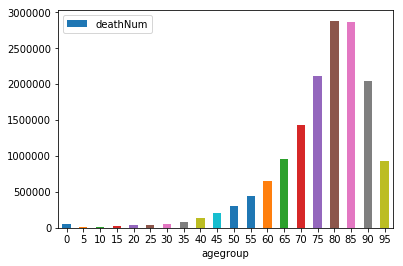

In [32]:
# Q2 
histForItaly('Italy')

#### Q2 Answer

The distribution of deaths by age group in Italy is very close to a normal distribution slightly deviated towards the right. 

The age group with the highest death number in Italy is 80-85. They have almost 3,000,000 deaths for all years for all causes. And the age group with the least death number is 5-10 and 10-15. Less than 1% of the deaths are from those two groups.

Generally, the deaths number increases as the age increases. This may not completely due to the body condition of aged population, but might also because of the population distribution of Italy. If they have an aged population, there will also be more deaths when the age increases.

Most of the deaths are among 60-90, and after 90, death number decreases again.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


     Cause   deathNum  Percentage
143   C349   426451.0    0.190419
227   C509   155895.0    0.069610
92    C189   143188.0    0.063936
76    C169   125679.0    0.056118
118   C259   120070.0    0.053614
0    Other  1268258.0    0.566303


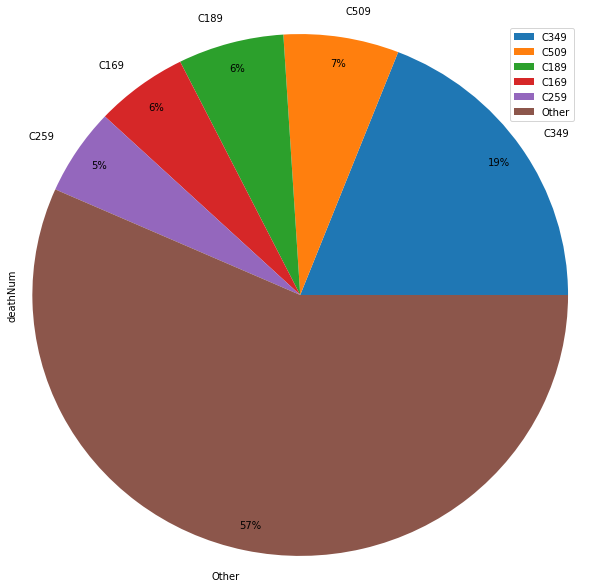

In [33]:
# Q3.
NeoDeath('Italy')

#### Q3 Answer

For the pie chart, small sections of the pie chart with label made it unclear to read. Therefore, only the top 5 causes are shown in the chart. The rest of the causes will be classified as 'other'. 

The top 5 most common causes of death for neoplasm across Italy are:

Cause |  Death Num   |  Percentage

C349  |  426451      |  19%

C509  |  155895      |  6%

C189  |  143188      |  6%

C169  |  125679      |  5%

C259  |  120070      |  5%

ICD-10 code ended with 9 indicates information not specified. For example, C349 indicates Malignant neoplasm of unspecified part of unspecified bronchus or lung. 

Through this pie chart, we can conclude that almost 20% of the death among neoplasm is due to cause C349. 

In [34]:
# Q4
rankNeoDeath('Australia')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Country     5020
Deaths22  7165.0
Deaths21  6281.0
Deaths20  5709.0
Deaths23  5512.0
Deaths19  4765.0


#### Q4 Answer

Top five age groups in Australia dying with a Neoplasms cause of death:

Deaths22  Deaths at age 80-84 years

Deaths21  Deaths at age 75-79 years

Deaths20  Deaths at age 70-74 years

Deaths23  Deaths at age 85-89 years

Deaths19  Deaths at age 65-69 years


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


     country1  country2
age                    
0    0.001941  0.002884
1    0.000038  0.000032
2    0.000024  0.000037
3    0.000037  0.000028
4    0.000024  0.000045
5    0.000028  0.000035
10   0.000034  0.000032
15   0.000022  0.000034
20   0.000033  0.000045
25   0.000032  0.000052
30   0.000058  0.000067
35   0.000090  0.000107
40   0.000200  0.000194
45   0.000354  0.000388
50   0.000675  0.000725
55   0.001196  0.001386
60   0.002031  0.002298
65   0.003251  0.003731
70   0.005247  0.005746
75   0.008040  0.008209
80   0.011357  0.011765
85   0.016287  0.016420
90   0.020774  0.020414
95   0.023344  0.022993


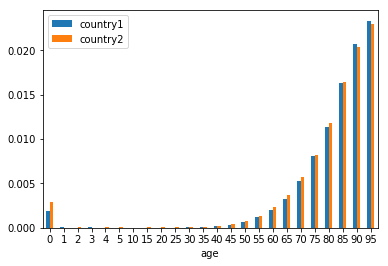

In [35]:
# Q5
compareCountries('Australia', 'Italy')

#### Q5 Answer

In this case, as parameters passed in are Australia and Italy, country 1 will be Australia and country 2 will be Italy.

Combine the information on population and deaths, the percentage of death due to neoplasm out of the population for each age groups for two different countries are shown in the graph below. There is a very slight difference between younger people apart from 0-year-old infants. Both of the country have almost 0% of young people dying because of neoplasm, between age group 1 to 30. However, both of the countries has a rapid increase in the percentage of death of neoplasm after the population reach the age 35. After age 75, more than 1% of the population died because neoplasm.

Comparing with Italy, Australia population has a lower percentage in death because of neoplasm for infants. For people above 90 however, australia population has a higher death rate because of neoplasm comparing to Italy population. 

In general, both countries does not have a significant difference in the frequency of death by neoplasm. 